In [1]:
import numpy as np

def gtoval_sph_deriv1(coords, exponents, coeffs, max_l):
    """
    Evaluate Gaussian-type orbitals with first derivatives in spherical coordinates at a set of specified Cartesian coordinates.
    
    Parameters:
        coords (ndarray): A (N, 3) NumPy array of Cartesian coordinates (x, y, z) at which to evaluate the GTOs.
        exponents (ndarray): A 1D NumPy array of GTO exponents.
        coeffs (ndarray): A 2D NumPy array of GTO contraction coefficients.
        max_l (int): The maximum angular momentum quantum number of the GTOs.
        
    Returns:
        gto_vals (ndarray): A 3D NumPy array of GTO values and their first derivatives with respect to the spatial coordinates.
            The shape of the array is (N, max_l+1, 2*max_l+2), where N is the number of evaluation points.
    """
    # Compute the spherical coordinates (r, theta, phi) from the Cartesian coordinates (x, y, z)
    r = np.linalg.norm(coords, axis=1)
    theta = np.arccos(coords[:, 2] / r)
    phi = np.arctan2(coords[:, 1], coords[:, 0])

    # Compute the GTO values and their first derivatives in spherical coordinates
    num_gto = exponents.size
    num_points = coords.shape[0]
    gto_vals = np.zeros((num_points, max_l+1, 2*max_l+2))

    for i in range(num_points):
        for n in range(num_gto):
            for l in range(max_l+1):
                for m in range(-l, l+1):
                    lm = l * (l + 1) + m
                    prefactor = coeffs[n, l] * (2 * exponents[n] / np.pi) ** (3/4)
                    radial_part = prefactor * np.exp(-exponents[n] * r[i]**2)
                    angular_part = np.real(sph_harm(m, l, phi[i], theta[i]))

                    # Evaluate the first derivative with respect to r
                    gto_vals[i, l, 2*lm] += radial_part * (-2*exponents[n]*r[i])
                    gto_vals[i, l, 2*lm+1] += radial_part * (-2*exponents[n]*r[i])

                    # Evaluate the first derivative with respect to theta
                    if l > 0:
                        prefactor2 = 0.5 * np.sqrt((l-m) * (l+m+1))
                        angular_part_theta = prefactor2 * (sph_harm(m-1, l, phi[i], theta[i]) - sph_harm(m+1, l, phi[i], theta[i]))
                        gto_vals[i, l-1, 2*lm] += radial_part * angular_part_theta / r[i]
                        gto_vals[i, l-1, 2*lm+1] -= radial_part * angular_part_theta / r[i]

                    # Evaluate the first derivative with respect to phi
                    if m != 0:
                        prefactor2 = -1j * m / np.sqrt((l-m) * (l+m))
                        angular_part_phi = prefactorgg

In [2]:
import numpy as np
from pyscf import gto, dft

# Define the H2O molecule in STO-3G basis
mol = gto.M(
    atom='O 0 0 0; H 0 -0.757 0.587; H 0 0.757 0.587',
    basis='sto3g'
)

# Create a DFT object with the RKS method
mf = dft.RKS(mol)

# Generate grid and weights
grid = dft.Grids(mol)
grid.build()

# Call eval_gto
#ao_value = mol.eval_gto('GTOval', grid.coords)
ao_value = mol.eval_gto('GTOval_sph_deriv1', grid.coords, 4)

print("Grid points:", grid.coords.shape[0])
print("AO values shape:", ao_value.shape)

Grid points: 34312
AO values shape: (4, 34312, 7)


In [10]:
import warnings
import ctypes
import numpy
from pyscf import lib
from pyscf.gto.moleintor import make_loc
from pyscf import __config__

BLKSIZE = 56  # must be equal to lib/gto/grid_ao_drv.h
NBINS = 100
CUTOFF = getattr(__config__, 'eval_gto_cutoff', 1e-15)

libcgto = lib.load_library('libcgto')


def _get_intor_and_comp(mol, eval_name, comp=None):
    if not ('_sph' in eval_name or '_cart' in eval_name or
            '_spinor' in eval_name):
        if mol.cart:
            eval_name = eval_name + '_cart'
        else:
            eval_name = eval_name + '_sph'

    if comp is None:
        if '_spinor' in eval_name:
            fname = eval_name.replace('_spinor', '')
            comp = _GTO_EVAL_FUNCTIONS.get(fname, (None,None))[1]
        else:
            fname = eval_name.replace('_sph', '').replace('_cart', '')
            comp = _GTO_EVAL_FUNCTIONS.get(fname, (None,None))[0]
        if comp is None:
            warnings.warn('Function %s not found.  Set its comp to 1' % eval_name)
            comp = 1
    return eval_name, comp


def eval_gto(mol, eval_name, coords, comp=None, shls_slice=None, non0tab=None,
             ao_loc=None, cutoff=None, out=None):
    r'''Evaluate AO function value on the given grids,

    Args:
        eval_name : str

            ========================  ======  =======================
            Function                  comp    Expression
            ========================  ======  =======================
            "GTOval_sph"              1       |AO>
            "GTOval_ip_sph"           3       nabla |AO>
            "GTOval_ig_sph"           3       (#C(0 1) g) |AO>
            "GTOval_ipig_sph"         9       (#C(0 1) nabla g) |AO>
            "GTOval_cart"             1       |AO>
            "GTOval_ip_cart"          3       nabla |AO>
            "GTOval_ig_cart"          3       (#C(0 1) g)|AO>
            "GTOval_sph_deriv1"       4       GTO value and 1st order GTO values
            "GTOval_sph_deriv2"       10      All derivatives up to 2nd order
            "GTOval_sph_deriv3"       20      All derivatives up to 3rd order
            "GTOval_sph_deriv4"       35      All derivatives up to 4th order
            "GTOval_sp_spinor"        1       sigma dot p |AO> (spinor basis)
            "GTOval_ipsp_spinor"      3       nabla sigma dot p |AO> (spinor basis)
            "GTOval_ipipsp_spinor"    9       nabla nabla sigma dot p |AO> (spinor basis)
            ========================  ======  =======================

        atm : int32 ndarray
            libcint integral function argument
        bas : int32 ndarray
            libcint integral function argument
        env : float64 ndarray
            libcint integral function argument

        coords : 2D array, shape (N,3)
            The coordinates of the grids.

    Kwargs:
        comp : int
            Number of the components of the operator
        shls_slice : 2-element list
            (shl_start, shl_end).
            If given, only part of AOs (shl_start <= shell_id < shl_end) are
            evaluated.  By default, all shells defined in mol will be evaluated.
        non0tab : 2D bool array
            mask array to indicate whether the AO values are zero.  The mask
            array can be obtained by calling :func:`dft.gen_grid.make_mask`
        cutoff : float
            AO values smaller than cutoff will be set to zero. The default
            cutoff threshold is ~1e-22 (defined in gto/grid_ao_drv.h)
        out : ndarray
            If provided, results are written into this array.

    Returns:
        2D array of shape (N,nao) Or 3D array of shape (\*,N,nao) to store AO
        values on grids.

    Examples:

    >>> mol = gto.M(atom='O 0 0 0; H 0 0 1; H 0 1 0', basis='ccpvdz')
    >>> coords = numpy.random.random((100,3))  # 100 random points
    >>> ao_value = mol.eval_gto("GTOval_sph", coords)
    >>> print(ao_value.shape)
    (100, 24)
    >>> ao_value = mol.eval_gto("GTOval_ig_sph", coords)
    >>> print(ao_value.shape)
    (3, 100, 24)
    '''
    eval_name, comp = _get_intor_and_comp(mol, eval_name, comp)

    atm = numpy.asarray(mol._atm, dtype=numpy.int32, order='C')
    bas = numpy.asarray(mol._bas, dtype=numpy.int32, order='C')
    env = numpy.asarray(mol._env, dtype=numpy.double, order='C')
    coords = numpy.asarray(coords, dtype=numpy.double, order='F')
    natm = atm.shape[0]
    nbas = bas.shape[0]
    ngrids = coords.shape[0]

    if ao_loc is None:
        ao_loc = make_loc(bas, eval_name)

    if shls_slice is None:
        shls_slice = (0, nbas)
    sh0, sh1 = shls_slice
    nao = ao_loc[sh1] - ao_loc[sh0]
    if 'spinor' in eval_name:
        ao = numpy.ndarray((2,comp,nao,ngrids), dtype=numpy.complex128,
                           buffer=out).transpose(0,1,3,2)
    else:
        ao = numpy.ndarray((comp,nao,ngrids), buffer=out).transpose(0,2,1)

    if non0tab is None:
        if cutoff is None:
            non0tab = numpy.ones(((ngrids+BLKSIZE-1)//BLKSIZE,nbas),
                                 dtype=numpy.uint8)
        else:
            non0tab = make_screen_index(mol, coords, shls_slice, cutoff)

    drv = getattr(libcgto, eval_name)
    drv(ctypes.c_int(ngrids),
        (ctypes.c_int*2)(*shls_slice), ao_loc.ctypes.data_as(ctypes.c_void_p),
        ao.ctypes.data_as(ctypes.c_void_p),
        coords.ctypes.data_as(ctypes.c_void_p),
        non0tab.ctypes.data_as(ctypes.c_void_p),
        atm.ctypes.data_as(ctypes.c_void_p), ctypes.c_int(natm),
        bas.ctypes.data_as(ctypes.c_void_p), ctypes.c_int(nbas),
        env.ctypes.data_as(ctypes.c_void_p))

    if comp == 1:
        if 'spinor' in eval_name:
            ao = ao[:,0]
        else:
            ao = ao[0]
    return ao


assert np.allclose(ao_value , eval_gto(mol, 'GTOval_sph_deriv1', grid.coords, 4))

In [19]:
import warnings
import ctypes
import numpy
from pyscf import lib
from pyscf.gto.moleintor import make_loc
from pyscf import __config__

BLKSIZE = 56  # must be equal to lib/gto/grid_ao_drv.h
NBINS = 100
CUTOFF = getattr(__config__, 'eval_gto_cutoff', 1e-15)

libcgto = lib.load_library('libcgto')


def _get_intor_and_comp(mol, eval_name, comp=None):
    if not ('_sph' in eval_name or '_cart' in eval_name or
            '_spinor' in eval_name):
        if mol.cart:
            eval_name = eval_name + '_cart'
        else:
            eval_name = eval_name + '_sph'

    if comp is None:
        if '_spinor' in eval_name:
            fname = eval_name.replace('_spinor', '')
            comp = _GTO_EVAL_FUNCTIONS.get(fname, (None,None))[1]
        else:
            fname = eval_name.replace('_sph', '').replace('_cart', '')
            comp = _GTO_EVAL_FUNCTIONS.get(fname, (None,None))[0]
        if comp is None:
            warnings.warn('Function %s not found.  Set its comp to 1' % eval_name)
            comp = 1
    return eval_name, comp


def eval_gto(mol, eval_name, coords, comp=None, shls_slice=None, non0tab=None,
             ao_loc=None, cutoff=None, out=None):
    #eval_name, comp = _get_intor_and_comp(mol, eval_name, comp)
    #print(eval_name, comp)
    eval_name, comp = "GTOval_sph_deriv1", 4

    atm = numpy.asarray(mol._atm, dtype=numpy.int32, order='C')
    bas = numpy.asarray(mol._bas, dtype=numpy.int32, order='C')
    env = numpy.asarray(mol._env, dtype=numpy.double, order='C')
    coords = numpy.asarray(coords, dtype=numpy.double, order='F')
    natm = atm.shape[0]
    nbas = bas.shape[0]
    ngrids = coords.shape[0]

    ao_loc = make_loc(bas, eval_name)

    shls_slice = (0, nbas)
    sh0, sh1 = shls_slice
    nao = ao_loc[sh1] - ao_loc[sh0]
    ao = numpy.ndarray((comp,nao,ngrids), buffer=out).transpose(0,2,1)

    non0tab = numpy.ones(((ngrids+BLKSIZE-1)//BLKSIZE,nbas), dtype=numpy.uint8)

    drv = getattr(libcgto, eval_name)
    drv(ctypes.c_int(ngrids),
        (ctypes.c_int*2)(*shls_slice), ao_loc.ctypes.data_as(ctypes.c_void_p),
        ao.ctypes.data_as(ctypes.c_void_p),
        coords.ctypes.data_as(ctypes.c_void_p),
        non0tab.ctypes.data_as(ctypes.c_void_p),
        atm.ctypes.data_as(ctypes.c_void_p), ctypes.c_int(natm),
        bas.ctypes.data_as(ctypes.c_void_p), ctypes.c_int(nbas),
        env.ctypes.data_as(ctypes.c_void_p))

          
    return ao


assert np.allclose(ao_value , eval_gto(mol, 'GTOval_sph_deriv1', grid.coords, 4))

In [21]:
import numpy as np
from scipy.special import sph_harm

def eval_gto_np(mol, coords):
    eval_name = 'GTOval'
    ngrids = coords.shape[0]
    nao = mol.nao
    nbas = mol.nbas

    ao_values = np.zeros((ngrids, nao))

    for i in range(nbas):
        l = mol.bas_angular(i)  # Angular momentum
        nprim = mol.bas_nprim(i)  # Number of primitives
        exps = mol.bas_exp(i)  # Exponents
        coeffs = mol.bas_ctr_coeff(i)  # Contraction coefficients
        atom_id = mol.bas_atom(i)  # Atom id
        r_atom = mol.atom_coord(atom_id)  # Atom coordinates

        r_rel = coords - r_atom  # Relative coordinates of the grid points
        r2 = np.sum(r_rel ** 2, axis=-1)  # Square of the distance to the atom

        # Evaluate radial part of the AOs
        radial_values = np.zeros((ngrids, nprim))
        for p in range(nprim):
            radial_values[:, p] = np.exp(-exps[p] * r2) * coeffs[p]
        radial_values = np.sum(radial_values, axis=-1)

        # Evaluate spherical harmonics for the AOs
        if l > 0:
            theta, phi = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / np.sqrt(r2))
            sph_values = np.zeros((ngrids, 2 * l + 1), dtype=np.complex128)
            m = np.arange(-l, l + 1)
            for k, m_k in enumerate(m):
                sph_values[:, k] = sph_harm(m_k, l, phi, theta)
            sph_values = np.real(sph_values)
        else:
            sph_values = np.ones((ngrids, 1))

        # Combine radial and angular parts of the AOs
        ao_shell_values = radial_values[:, np.newaxis] * sph_values

        # Store AO values for the shell
        ao_slice = mol.aoslice_by_atom()[atom_id, 2:4]
        ao_values[:, ao_slice[0]:ao_slice[1]] = ao_shell_values

    return ao_values

assert np.allclose(ao_value[0] , eval_gto_np(mol, grid.coords))

ValueError: could not broadcast input array from shape (34312,3) into shape (34312,5)

(34312, 7)
(34312, 7)


AssertionError: 

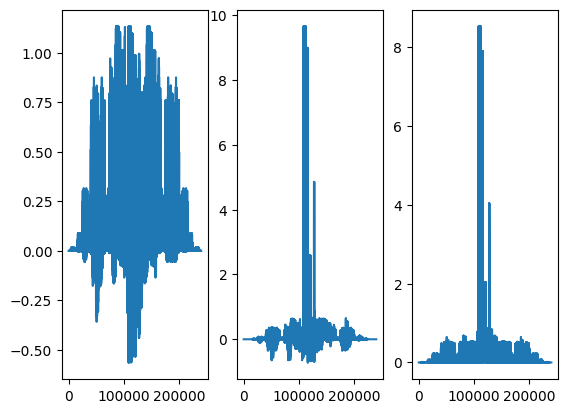

In [3]:
import numpy as np
from scipy.special import sph_harm

def eval_gto_np(mol, coords):
    eval_name = 'GTOval'
    ngrids = coords.shape[0]
    nao = mol.nao
    nbas = mol.nbas

    ao_values = np.zeros((ngrids, nao))

    ao_start = 0
    for i in range(nbas):
        l = mol.bas_angular(i)  # Angular momentum
        nprim = mol.bas_nprim(i)  # Number of primitives
        exps = mol.bas_exp(i)  # Exponents
        coeffs = mol.bas_ctr_coeff(i)  # Contraction coefficients
        atom_id = mol.bas_atom(i)  # Atom id
        r_atom = mol.atom_coord(atom_id)  # Atom coordinates

        r_rel = coords - r_atom  # Relative coordinates of the grid points
        r2 = np.sum(r_rel ** 2, axis=-1)  # Square of the distance to the atom

        # Evaluate radial part of the AOs
        radial_values = np.zeros((ngrids, nprim))
        for p in range(nprim):
            radial_values[:, p] = np.exp(-exps[p] * r2) * coeffs[p]
        radial_values = np.sum(radial_values, axis=-1)

        # Evaluate spherical harmonics for the AOs
        if l > 0:
            theta, phi = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / np.sqrt(r2))
            sph_values = np.zeros((ngrids, 2 * l + 1), dtype=np.complex128)
            m = np.arange(-l, l + 1)
            for k, m_k in enumerate(m):
                sph_values[:, k] = sph_harm(m_k, l, phi, theta)
            sph_values = np.real(sph_values)
        else:
            sph_values = np.ones((ngrids, 1))

        # Combine radial and angular parts of the AOs
        ao_shell_values = radial_values[:, np.newaxis] * sph_values

        # Store AO values for the shell
        ao_end = ao_start + ao_shell_values.shape[1]
        ao_values[:, ao_start:ao_end] = ao_shell_values
        ao_start = ao_end

    return ao_values
  

a = eval_gto_np(mol, grid.coords)
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1,3)

ax[0].plot(a.reshape(-1))
ax[1].plot(ao_value[0].reshape(-1))
ax[2].plot(np.abs(ao_value[0].reshape(-1)-a.reshape(-1)))



print(a.shape)
print(ao_value[0].shape)
assert np.allclose(ao_value[3] , a)

In [31]:
import numpy as np
from pyscf import gto, dft
mol = gto.M( atom=' H 0 -0.757 0.587; H 0 0.757 0.587', basis='sto3g')
mf = dft.RKS(mol)
grid = dft.Grids(mol)
grid.build()
cart = mol.eval_gto('GTOval_cart', grid.coords).reshape(1, -1)
sph = mol.eval_gto('GTOval_sph', grid.coords).reshape(1, -1)
print(cart.shape, sph.shape)
assert np.allclose(cart, sph)

(1, 40096) (1, 40096)


In [1]:
2+2

4

(1, 40096)
(4, 20048, 2)
Grid points: 20048
AO values shape: (4, 20048, 2)
(4, 20048, 2) (20048, 3)
0.0391095822146138
0.062251932027197


AssertionError: AO values do not match within the specified tolerance

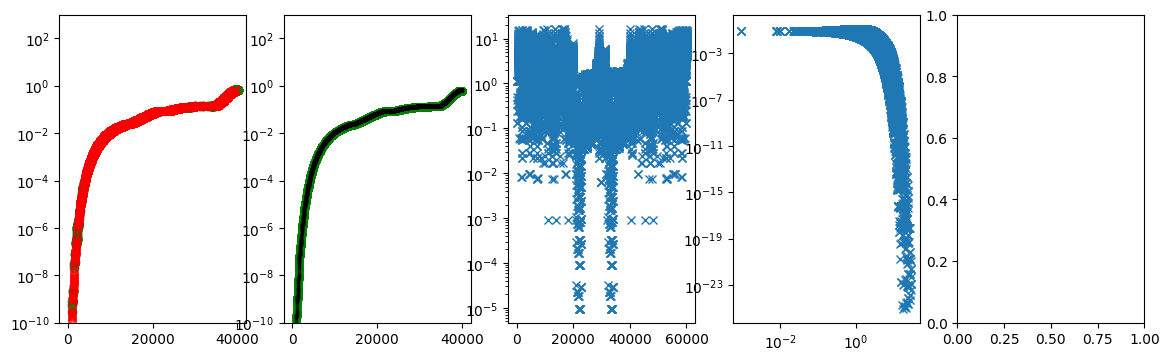

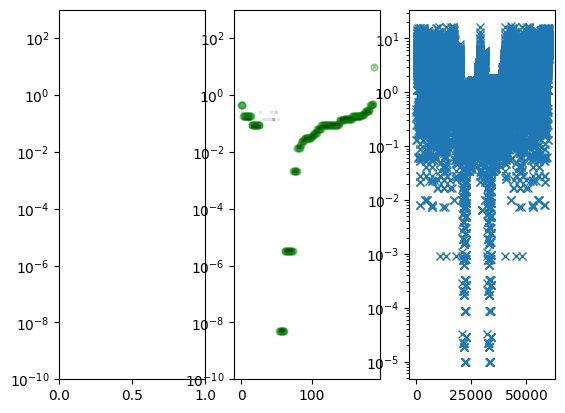

In [27]:
import numpy as np
from scipy.special import sph_harm

def eval_gto_np(mol, coords):
    ngrids = coords.shape[0]
    nao = mol.nao
    nbas = mol.nbas
    ao_values = np.zeros((ngrids, nao))

    ao_start = 0
    for i in range(nbas):
        l = mol.bas_angular(i)  # Angular momentum
        nprim = mol.bas_nprim(i)  # Number of primitives
        exps = mol.bas_exp(i)  # Exponents
        coeffs = mol.bas_ctr_coeff(i)  # Contraction coefficients
        atom_id = mol.bas_atom(i)  # Atom id
        r_atom = mol.atom_coord(atom_id)  # Atom coordinates

        print(coords.shape, r_atom.shape)
        r_rel = coords - r_atom[np.newaxis, :] # Relative coordinates of the grid points
        r = np.sqrt(np.sum(r_rel ** 2, axis=-1))  # Distance to the atom

        # Evaluate radial part of the AOs
        radial_values = np.zeros((ngrids, nprim))
        from scipy.special import gammaln
        for p in range(nprim):
            log_norm = ((3 / 4) * np.log(2 * exps[p] / np.pi) + 0.5 * (l * np.log(4 * exps[p]) - gammaln(2 * l + 3 / 2)))
            norm = np.exp(log_norm)
            #radial_values[:, p] = norm * np.exp(-exps[p] * r**2) * coeffs[p] * r**l #* np.sign(r)
            radial_values[:, p] = norm * np.exp(-exps[p] * r**2) * coeffs[p] * r**l #* np.sign(r)
        radial_values = np.sum(radial_values, axis=-1)

        # Evaluate spherical harmonics for the AOs
        '''if l > 0:
            print("l")
            theta, phi = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / r)
            #phi, theta = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / r)
            #phi, theta = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / r)

            sph_values = np.zeros((ngrids, 2 * l + 1), dtype=np.complex128)
            m = np.arange(-l, l + 1)
            for k, m_k in enumerate(m):
                sph_values[:, k] = sph_harm(m_k, l, phi, theta)
            sph_values = np.real(sph_values)
        else:
            sph_values = np.ones((ngrids, 1)) * 0.94139626'''
        # Evaluate spherical harmonics for the AOs
        print(l)
        if l == 0:
            sph_values = np.ones((ngrids, 1)) * 0.94139626
        elif l == 1:
            #theta, phi = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / r)
            theta, phi = np.arccos(r_rel[:, 2] / r), np.arctan2(r_rel[:, 1], r_rel[:, 0])
            sph_values = np.zeros((ngrids, 3), dtype=np.complex128)
            for k, m_k in enumerate([-1, 0, 1]):
                sph_values[:, k] = sph_harm(m_k, l, phi, theta)
            sph_values = np.real(sph_values)
        else:
            theta, phi = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / r)
            #phi, theta = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / r)
            #phi, theta = np.arctan2(r_rel[:, 1], r_rel[:, 0]), np.arccos(r_rel[:, 2] / r)

            sph_values = np.zeros((ngrids, 2 * l + 1), dtype=np.complex128)
            m = np.arange(-l, l + 1)
            for k, m_k in enumerate(m):
                sph_values[:, k] = sph_harm(m_k, l, phi, theta)
            sph_values = np.real(sph_values)
        
        # Combine radial and angular parts of the AOs
        ao_shell_values = radial_values[:, np.newaxis] * sph_values

        # Store AO values for the shell
        ao_end = ao_start + ao_shell_values.shape[1]
        ao_values[:, ao_start:ao_end] = ao_shell_values
        ao_start = ao_end

    return ao_values

def eval_gto_np_cartesian(mol, coords):
    ngrids = coords.shape[0]
    #nao = mol.nao_cart
    nao = mol.nao_nr() 
    nbas = mol.nbas
    ao_values = np.zeros((ngrids, nao))

    ao_start = 0
    for i in range(nbas):
        l = mol.bas_angular(i)  # Angular momentum
        nprim = mol.bas_nprim(i)  # Number of primitives
        exps = mol.bas_exp(i)  # Exponents
        coeffs = mol.bas_ctr_coeff(i)  # Contraction coefficients
        atom_id = mol.bas_atom(i)  # Atom id
        r_atom = mol.atom_coord(atom_id)  # Atom coordinates

        r_rel = coords - r_atom[np.newaxis, :] # Relative coordinates of the grid points
        r = np.sqrt(np.sum(r_rel ** 2, axis=-1))  # Distance to the atom

        # Evaluate radial part of the AOs
        radial_values = np.zeros((ngrids, nprim))
        from scipy.special import gammaln
        for p in range(nprim):
            log_norm = ((3 / 4) * np.log(2 * exps[p] / np.pi) + 0.5 * (l * np.log(4 * exps[p]) - gammaln(2 * l + 3 / 2)))
            norm = np.exp(log_norm)
            radial_values[:, p] = norm * np.exp(-exps[p] * r**2) * coeffs[p] * r**l
        radial_values = np.sum(radial_values, axis=-1)

        # Evaluate cartesian Gaussian functions for the AOs
        cart_values = []
        for lx in range(l+1):
            for ly in range(l+1-lx):
                lz = l - lx - ly
                cart_values.append((r_rel[:, 0] ** lx) * (r_rel[:, 1] ** ly) * (r_rel[:, 2] ** lz))
        cart_values = np.column_stack(cart_values)

        # Combine radial and cartesian Gaussian parts of the AOs
        ao_shell_values = radial_values[:, np.newaxis] * cart_values

        # Store AO values for the shell
        ao_end = ao_start + ao_shell_values.shape[1]
        ao_values[:, ao_start:ao_end] = ao_shell_values
        ao_start = ao_end

    return ao_values

import matplotlib.pyplot as plt 

import numpy as np
from pyscf import gto, dft

# Define the H2O molecule in STO-3G basis
mol = gto.M(
    atom=' H 0 -0.757 0.587; H 0 0.757 0.587',
    #atom=' H 0 -0.757 0.587; H 0 0.757 0.587; O 0 0 0',
    #atom='H 0 -0.757 0.587',
    basis='sto3g'
)

# Create a DFT object with the RKS method
mf = dft.RKS(mol)

# Generate grid and weights
grid = dft.Grids(mol)
grid.build()

#grid.coords = np.clip(grid.coords, 1e-10, 1e10)
grid.coords[grid.coords<1e-20] = 0
grid.coords[grid.coords>1e10] = 0


# Call eval_gto
ao_value = mol.eval_gto('GTOval', grid.coords).reshape(1, -1)
print(ao_value.shape)
ao_value = mol.eval_gto('GTOval_sph_deriv1', grid.coords, 4)
print(ao_value.shape)

print("Grid points:",     grid.coords.shape[0])
print("AO values shape:", ao_value.shape)

#a = eval_gto_np(mol, grid.coords.astype(np.float64))  
a = eval_gto_np_cartesian(mol, grid.coords.astype(np.float64))  
fig, ax = plt.subplots(1,5, figsize=(14, 4))
result = a #*16.06375846 

print(ao_value.shape, grid.coords.shape)


diff =  np.abs(a.reshape(-1)-ao_value[0].reshape(-1))
a =a .reshape(-1)
xs = np.arange(a.shape[0])
indxs = np.argsort(ao_value[0].reshape(-1))
ax[0].plot(xs[diff<1e-5], a[indxs][diff<1e-5], 'go', alpha=0.1)
ax[0].plot(xs[diff>1e-5], a[indxs][diff>1e-5], 'rx', alpha=0.1)
ax[0].set_yscale("log")
ax[0].set_ylim([1e-10, 1e3])


# plot grid/val?
ax[1].plot(np.abs(ao_value[0]).reshape(-1)[indxs], 'go', ms=5, alpha=0.3)
ax[1].plot(np.abs(a).reshape(-1)[indxs], 'xk', ms=2, alpha=0.1)
ax[1].set_yscale("log")
ax[1].set_ylim([1e-10, 1e3])
#ax[1].plot(np.abs(ao_value[0].reshape(-1)[indxs]-a.reshape(-1)[indxs]), 'xk', ms=2)

ax[2].plot(grid.coords.reshape(-1), 'x')
ax[2].set_yscale("log")



ax[3].plot(np.sum(grid.coords[:, :], axis=-1), ao_value[0, :, 0], 'x')
ax[3].set_yscale("log")
ax[3].set_xscale("log")

#ax[4].plot(np.abs(ao_value[0]).reshape(-1),a.reshape(-1), 'x')
#print(np.abs(ao_value[0]).reshape(-1)/a.reshape(-1))
#print((np.abs(diff)/np.abs(ao_value[0].reshape(-1))))

#ax[3].plot(np.abs(a).reshape(-1), 'go', alpha=0.3, ms=8)
#ax[3].plot(np.abs(ao_value[0]).reshape(-1), 'kx', alpha=0.3, ms=2)
#ax[3].plot(np.abs(a-ao_value[0]).reshape(-1), 'rx', alpha=0.3, ms=1)
#ax[3].set_yscale("log")

#for b in ax: 
#    b.set_yscale("log")
#    #b.set_xscale("log")
#
#    b.set_ylim([1e-10, 1e3])
#    #b.set_xlim([1e-10, 1e3])


print(np.max(np.abs(ao_value[0]-result)))
print(np.max(np.abs(ao_value[0]-result))/np.max(np.abs(ao_value[0])))

#assert np.allclose(ao_value[0] , result, atol=1e-5)

import numpy as np
from pyscf import gto

# Define test molecule (H2O) and basis set
mol_str = "O 0 0 0; H 0.758602 0.000000 0.504284; H 0.758602 0.000000 -0.504284"
basis = "sto-3g"

# Create a PySCF Mole object and build the molecule
mol = gto.Mole()
mol.atom = mol_str
mol.basis = basis
mol.build()

# Generate a grid for evaluation (e.g., a small 3D grid around the molecule)
n_points = 3
x = np.linspace(-1, 1, n_points)
y = np.linspace(-1, 1, n_points)
z = np.linspace(-1, 1, n_points)
grid_coords = np.array(np.meshgrid(x, y, z)).T.reshape(-1, 3)

# Evaluate the AO values using your eval_gto_np function and PySCF's built-in eval_gto function
ao_values_custom = eval_gto_np_cartesian(mol, grid_coords)
ao_values_pyscf = mol.eval_gto('GTOval', grid_coords)

fig, ax = plt.subplots(1,3)

diff =  np.abs(a.reshape(-1)-ao_value[0].reshape(-1))
ao_value = ao_values_pyscf.reshape(1, -1, 1)
a =ao_values_custom .reshape(-1)
xs = np.arange(a.shape[0])
indxs = np.argsort(ao_value[0].reshape(-1))
#ax[0].plot(xs[diff<1e-5], a[indxs][diff<1e-5], 'go', alpha=0.1)
#ax[0].plot(xs[diff>1e-5], a[indxs][diff>1e-5], 'rx', alpha=0.1)
ax[0].set_yscale("log")
ax[0].set_ylim([1e-10, 1e3])


# plot grid/val?
ax[1].plot(np.abs(ao_value[0]).reshape(-1)[indxs], 'go', ms=5, alpha=0.3)
ax[1].plot(np.abs(a).reshape(-1)[indxs], 'xk', ms=2, alpha=0.1)
ax[1].set_yscale("log")
ax[1].set_ylim([1e-10, 1e3])
#ax[1].plot(np.abs(ao_value[0].reshape(-1)[indxs]-a.reshape(-1)[indxs]), 'xk', ms=2)

ax[2].plot(grid.coords.reshape(-1), 'x')
ax[2].set_yscale("log")


#ax[3].plot(np.sum(grid.coords[:, :], axis=-1), ao_value[0, :, 0], 'x')
#ax[3].set_yscale("log")
#ax[3].set_xscale("log")

# Compare the results using np.allclose with a suitable tolerance
tolerance = 1e-6
assert np.allclose(ao_values_custom, ao_values_pyscf, atol=tolerance), "AO values do not match within the specified tolerance"

Grid points: 20048
AO values shape: (4, 20048, 2)
(20048, 2)
(4, 20048, 2) (20048, 3)
0.9271606081091271
1.4757902281564386


AssertionError: 

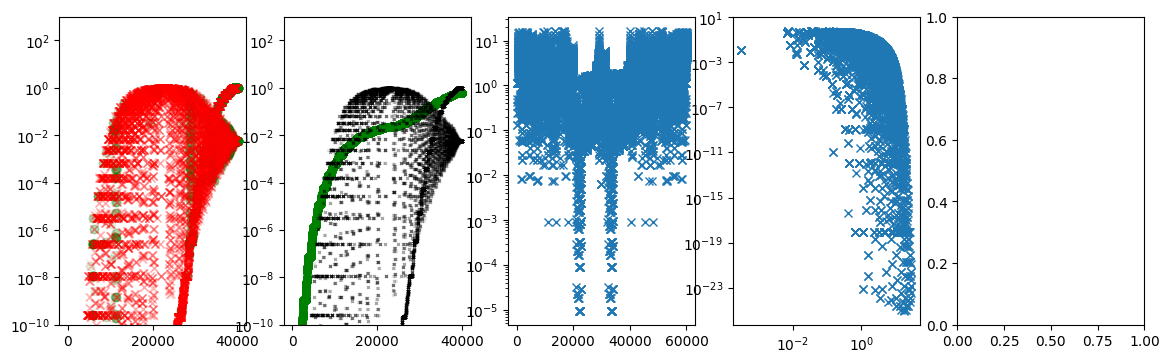

In [115]:

import matplotlib.pyplot as plt 

import numpy as np
from pyscf import gto, dft

def basis_build(mol):
  batch, l, exponents, coefficients, centers = [], [], [], [], []
  for i in range(mol.nbas):
      nprim = mol.bas_nprim(i)
      batch.append(i * np.ones((nprim)))
      l.append(mol.bas_angular(i) * np.ones((nprim), dtype=np.int32))
      exponents.append(mol.bas_exp(i))
      coefficients.append(mol.bas_ctr_coeff(i).flatten())
      Ra = mol.atom_coord(mol.bas_atom(i))
      centers.append(np.tile(Ra.reshape((1,3)), (nprim,1)))
      
  keys = ["batch", "l", "exponents", "coefficients", "centers"]
  values = map(np.concatenate, [batch, l, exponents, coefficients, centers])
  return dict(zip(keys, values))

def eval_radial(basis, pos):
    from scipy.special import factorial2
    r_rel = (pos[:, np.newaxis] - basis["centers"])
    rsq = np.sum(r_rel ** 2, axis=-1)
    r = np.sqrt(rsq)
    norm = 2 * (2 * basis["exponents"]) ** (3/4) / (np.pi) ** (1/4) 
    norm *= np.sqrt( 2 ** basis["l"] / factorial2(2 * basis["l"] + 1))
    #radial = (np.sqrt(2 * basis["exponents"]) * r) ** basis["l"]
    radial = r ** basis["l"]

    radial *= np.exp(- basis["exponents"] * rsq )
    radial *= norm * basis["coefficients"]
    return radial

def eval_angular(basis, pos):
    r_rel = (pos[:, np.newaxis] - basis["centers"])
    r = np.sqrt(np.sum(r_rel ** 2, axis=-1))
    phi, theta = np.arctan2(r_rel[:, :, 1], r_rel[:, :, 0]), np.arccos(r_rel[:, :, 2] / r)

    unique_l = np.unique(basis["l"])
    sph_values = {}
    for l_val in unique_l:
        if l_val > 0:
            m = np.arange(-l_val, l_val + 1)
            sph_values_l = np.zeros((pos.shape[0], basis["centers"].shape[0], 2 * l_val + 1), dtype=np.complex128)
            for k, m_k in enumerate(m):
                sph_values_l[:, :, k] = sph_harm(m_k, l_val, phi, theta)
            sph_values[l_val] = np.real(sph_values_l)
        else:
            sph_values[l_val] = np.ones((pos.shape[0], basis["centers"].shape[0], 1))

    return sph_values

# Define the H2O molecule in STO-3G basis
mol = gto.M(
    atom=' H 0 -0.757 0.587; H 0 0.757 0.587',
    #atom=' H 0 -0.757 0.587; H 0 0.757 0.587; O 0 0 0',
    #atom='H 0 -0.757 0.587',
    basis='sto3g'
)

basis = basis_build(mol)
radial = eval_radial(basis, grid.coords)
angular = eval_angular(basis, grid.coords)

ao_values = np.zeros((grid.coords.shape[0], mol.nao))
ao_start = 0
for i in range(mol.nbas):
    l = basis["l"][i]
    ao_end = ao_start + (2 * l + 1)
    ao_values[:, ao_start:ao_end] = radial[:, i, np.newaxis] * angular[l][:, i, :]
    ao_start = ao_end



# Create a DFT object with the RKS method
mf = dft.RKS(mol)

# Generate grid and weights
grid = dft.Grids(mol)
grid.build()

# Call eval_gto
#ao_value = mol.eval_gto('GTOval', grid.coords)
ao_value = mol.eval_gto('GTOval_sph_deriv1', grid.coords, 4)

print("Grid points:",     grid.coords.shape[0])
print("AO values shape:", ao_value.shape)

a = ao_values 
fig, ax = plt.subplots(1,5, figsize=(14, 4))
result = a #*16.06375846 

print(ao_values.shape)

print(ao_value.shape, grid.coords.shape)


diff =  np.abs(a.reshape(-1)-ao_value[0].reshape(-1))
a =a .reshape(-1)
xs = np.arange(a.shape[0])
indxs = np.argsort(ao_value[0].reshape(-1))
ax[0].plot(xs[diff<1e-5], a[indxs][diff<1e-5], 'go', alpha=0.1)
ax[0].plot(xs[diff>1e-5], a[indxs][diff>1e-5], 'rx', alpha=0.1)
ax[0].set_yscale("log")
ax[0].set_ylim([1e-10, 1e3])


# plot grid/val?
ax[1].plot(np.abs(ao_value[0]).reshape(-1)[indxs], 'go', ms=5, alpha=0.3)
ax[1].plot(np.abs(a).reshape(-1)[indxs], 'xk', ms=2, alpha=0.1)
ax[1].set_yscale("log")
ax[1].set_ylim([1e-10, 1e3])
#ax[1].plot(np.abs(ao_value[0].reshape(-1)[indxs]-a.reshape(-1)[indxs]), 'xk', ms=2)

ax[2].plot(grid.coords.reshape(-1), 'x')
ax[2].set_yscale("log")



ax[3].plot(np.sum(grid.coords[:, :], axis=-1), ao_value[0, :, 0], 'x')
ax[3].set_yscale("log")
ax[3].set_xscale("log")

#ax[4].plot(np.abs(ao_value[0]).reshape(-1),a.reshape(-1), 'x')
#print(np.abs(ao_value[0]).reshape(-1)/a.reshape(-1))
#print((np.abs(diff)/np.abs(ao_value[0].reshape(-1))))

#ax[3].plot(np.abs(a).reshape(-1), 'go', alpha=0.3, ms=8)
#ax[3].plot(np.abs(ao_value[0]).reshape(-1), 'kx', alpha=0.3, ms=2)
#ax[3].plot(np.abs(a-ao_value[0]).reshape(-1), 'rx', alpha=0.3, ms=1)
#ax[3].set_yscale("log")

#for b in ax: 
#    b.set_yscale("log")
#    #b.set_xscale("log")
#
#    b.set_ylim([1e-10, 1e3])
#    #b.set_xlim([1e-10, 1e3])


print(np.max(np.abs(ao_value[0]-result)))
print(np.max(np.abs(ao_value[0]-result))/np.max(np.abs(ao_value[0])))

assert np.allclose(ao_value[0] , result, atol=1e-5)

In [5]:
import numpy as np

def eval_gto_np_v2(mol, coords):
    ngrids = coords.shape[0]
    nao = mol.nao
    coords = coords.T

    ao_values = np.zeros((ngrids, nao))

    for atom_id, (coord_atom, basis_atom, nprims_atom, nc_atom) in enumerate(zip(mol.atom_coords(), mol._basis, mol.nprims, mol._nao)):
        for shell_id, (shell, nprims, nc) in enumerate(zip(basis_atom, nprims_atom, nc_atom)):
            l = shell[0]
            alphas = np.asarray(shell[1::2], dtype=float)
            coeffs = np.asarray(shell[2::2], dtype=float)
            rvec = coords - coord_atom.reshape(3, 1)

            r2 = np.sum(rvec**2, axis=0)
            r = np.sqrt(r2)

            gto_prims = np.exp(-np.outer(alphas, r2)) * coeffs[:, None]
            gto_contr = np.sum(gto_prims, axis=0)

            if l > 0:
                r_pow_l = np.power(rvec, l)
                gto_contr = gto_contr * r_pow_l

            # Store AO values for the shell
            ao_slice = mol.aoslice_by_atom()[atom_id, 2:4]
            ao_values[:, ao_slice[0]:ao_slice[1]] = gto_contr.T

    return ao_values
import matplotlib.pyplot as plt 

a = eval_gto_np_v2(mol, grid.coords)
fig, ax = plt.subplots(1,3)

ax[0].plot(a.reshape(-1))
ax[1].plot(ao_value[0].reshape(-1))
ax[2].plot(np.abs(ao_value[0].reshape(-1)-a.reshape(-1)))


print(a.shape)
print(ao_value[0].shape)

assert np.allclose(ao_value[0] , a)

AttributeError: Mole object does not have method nprims

In [43]:
import numpy as np

def eval_gto_np_v2(mol, coords):
    ngrids = coords.shape[0]
    nao = mol.nao
    coords = coords.T

    ao_values = np.zeros((ngrids, nao))

    for atom_id, (coord_atom, basis_atom) in enumerate(zip(mol.atom_coords(), mol._basis)):
        for shell_id, shell in enumerate(basis_atom):
            l = shell[0]
            #alphas = np.asarray(shell[1::2], dtype=float)
            #coeffs = np.asarray(shell[2::2], dtype=float)
            prim_data = np.asarray(shell[1:], dtype=float)
            alphas = prim_data[::2]
            coeffs = prim_data[1::2]
            nprims = len(alphas)
            rvec = coords - coord_atom.reshape(3, 1)

            r2 = np.sum(rvec**2, axis=0)
            r = np.sqrt(r2)

            gto_prims = np.exp(-np.outer(alphas, r2)) * coeffs[:, None]
            gto_contr = np.sum(gto_prims, axis=0)

            if l > 0:
                r_pow_l = np.power(rvec, l)
                gto_contr = gto_contr * r_pow_l

            # Store AO values for the shell
            ao_slice = mol.aoslice_by_atom()[atom_id, 2:4]
            ao_values[:, ao_slice[0]:ao_slice[1]] = gto_contr.T

    return ao_values


a = eval_gto_np_v2(mol, grid.coords)
fig, ax = plt.subplots(1,3)

ax[0].plot(a.reshape(-1))
ax[1].plot(ao_value[0].reshape(-1))
ax[2].plot(np.abs(ao_value[0].reshape(-1)-a.reshape(-1)))


print(a.shape)
print(ao_value[0].shape)

assert np.allclose(ao_value[0] , a)

ValueError: could not convert string to float: ''

In [32]:
import numpy as np
from pyscf import gto, dft

# Define the molecular geometry and basis set
mol = gto.Mole()
mol.atom = '''
    O 0.0 0.0 0.0
    H 0.757 0.586 0.0
    H -0.757 0.586 0.0
'''
mol.basis = 'sto-3g'
mol.build()

# Create a grid for evaluating the GTO
grid = dft.Grids(mol)
grid.level = 3
grid.build()

# Evaluate the GTO on the grid
ao_value = mol.eval_gto("GTOval", grid.coords)
print("AO values on the grid:\n", ao_value)

AO values on the grid:
 [[ 2.86793185e-273  1.93974705e-017 -7.63385330e-017 ... -7.63385330e-017
   2.60308803e-011  6.40942549e-009]
 [ 0.00000000e+000  7.76379336e-021 -3.36249522e-020 ... -3.36249522e-020
   4.94398625e-013  2.11704378e-010]
 [ 0.00000000e+000  1.13509014e-025 -5.49201759e-025 ... -5.49201759e-025
   1.88061917e-015  1.63782535e-012]
 ...
 [ 0.00000000e+000  2.60515471e-037  1.55452829e-036 ...  1.81188851e-036
   3.76988066e-015  8.92298074e-019]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000 ...  0.00000000e+000
   0.00000000e+000  0.00000000e+000]
 [ 0.00000000e+000  0.00000000e+000  0.00000000e+000 ...  0.00000000e+000
   0.00000000e+000  0.00000000e+000]]


In [37]:
import numpy as np

def eval_gto_numpy(mol, grid_coords):
    ao_values = np.zeros((len(grid_coords), mol.nao))
    ao_offset = 0#mol.ao_offset

    for i in range(mol.natm):
        atom_basis = mol._bas[mol._atm[i, 2]:mol._atm[i, 3]]
        for j in range(len(atom_basis)):
            l = atom_basis[j, 1]
            n_primitives = atom_basis[j, 3]
            exponents = mol._env[atom_basis[j, 4]:atom_basis[j, 4] + n_primitives]
            coefficients = mol._env[atom_basis[j, 5]:atom_basis[j, 5] + n_primitives]
            #center = mol._env[mol._ptr_coord(i)]
            center = mol.atom_coord(i)


            if l == 0:
                ao_values[:, ao_offset] = eval_s_orbital(grid_coords, center, exponents, coefficients)
                ao_offset += 1
            elif l == 1:
                ao_values[:, ao_offset:ao_offset + 3] = eval_p_orbital(grid_coords, center, exponents, coefficients)
                ao_offset += 3

                print(ao_offset)

    return ao_values

def eval_s_orbital(grid_coords, center, exponents, coefficients):
    r2 = np.sum((grid_coords - center)**2, axis=1)
    gto_values = np.sum(coefficients * np.exp(-exponents * r2[:, np.newaxis]), axis=1)
    return gto_values

def eval_p_orbital(grid_coords, center, exponents, coefficients):
    r = grid_coords - center
    r2 = np.sum(r**2, axis=1)
    gto_values = np.zeros((len(grid_coords), 3))
    for i in range(3):
        gto_values[:, i] = np.sum(coefficients * r[:, i, np.newaxis] * np.exp(-exponents * r2[:, np.newaxis]), axis=1)
    return gto_values

# Evaluate GTO using the NumPy implementation
ao_value_numpy = eval_gto_numpy(mol, grid.coords)

# Compare the results
print("Difference between PySCF and NumPy implementation:", np.max(np.abs(ao_value - ao_value_numpy)))

4


ValueError: could not broadcast input array from shape (34312,3) into shape (34312,0)